## Image registration

**Deadline**: Upload this notebook (rename it as 'TP-ImageRegistration-Images-YOUR-SURNAME.ipynb') to E-Campus before the deadline (see E-campus for the exact timing).

**Goal**: The goal of this notebook is to implement the algorithms seen today for pixel-based image registration. Please complete the code where you see **XXXXXXXXXXXXXX**

You will first take two pictures of your right hand into two different positions. Please keep the same topology, ie do not bend or stick together two fingers for instance. 

If you can't take the pictures, you can use two pictures of my hand (see below).

In [1]:
if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='1XpgGRo839pBwIhb6h77xoG-NtHEg2DVd',
  dest_path='./Source.jpg')

  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='12FKfLjKreAksI3rEcDx4_oEn3qjAzEua',
  dest_path='./Target.jpg')
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
# You should write the absolute path of your working directory with the data
  workingDir='./'

You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data


We will use the skimage library to read and resize images, you can of course use others (openCV, pillow, scipy, etc.)

In [2]:
from skimage.io import imread
from skimage.transform import resize

import matplotlib.pyplot as plt
from numpy import linalg as LA
import numpy as np
import scipy.ndimage

The first thing to do is to create a function that creates the transformation matrix T. Please complete the following function following the rules explained in the header of the function.

In [3]:
def Tmatrix(scale=(1,1), rotationAngle=0, shearAngles=(0,0),translation=(0,0),elation=(0,0),reflection=(False,False)):
    ''' 
    Transformation matrix defined as the composition of 6 possible geometric
    transformations: Reflection (Re), Rotation (R), Scaling (S), Shear (Sh),
    Translation (T) and Elation (E).
    For the linear transformation part, we assume this composition: 
        A = Re * R * S * Sh
        
    Inputs: 
            scale: is a tuple with sx and sy (two scalar values)
            rotationAngle: is an angle in degrees (scalar value)
            shearAngles: is a tuple with the two shear angles in degrees (scalar value)
            translation: is a tuple with tx and ty (scalar values)
            elation: is a tuple containing the elation part (scalar values)
            reflection: is a tuple of Boolean values indicating wheter to reflect with respect to x and y axis
            
    Output:
            T: the 3x3 transformation matrix (homogeneous coordinates)
    '''    
    
    if len(scale) != 2:
        raise ValueError("scale should be a tuple of length 2")
    if len(shearAngles)!= 2:
        raise ValueError("shearAngles should be a tuple of length 2")
    if len(translation)!= 2:
        raise ValueError("translation should be a tuple of length 2")
    if len(elation)!= 2:
        raise ValueError("elation should be a tuple of length 2")
    if len(reflection)!= 2:
        raise ValueError("reflection should be a tuple of length 2")
    if type(reflection[0])!= bool or type(reflection[1]) != bool:
        raise ValueError("reflection should contain two boolean values")       
    if np.ndim(rotationAngle) != 0:
        raise ValueError("rotationAngle should be a scalar")
        
    # transform angles from degrees to radians    
    theta = rotationAngle *2*np.pi/360
    lamda1= shearAngles[0]*2*np.pi/360
    lamda2=shearAngles[1]*2*np.pi/360
    # compute T  
#    A = Re * R * S * Sh
    ref1=-( reflection[0]*2-1)
    ref2=-(reflection[1]*2-1)
    
    Re = np.array([[ref1,0],[0,ref2]])
    R= np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    S = np.array([[scale[0],0],[0,scale[1]]])
    Sh = np.array([[1,lamda1],[lamda2,1]])
    A = Re@R@S@Sh
    a= A[0,0]
    b=A[0,1]
    c=A[1,0]
    d=A[1,1]
    T = np .array([[a,b,translation[0]],[c,d,translation[1]],[elation[0],elation[1],1]])
    return T

Test here, your function.

In [4]:
## Define Transformation
T=Tmatrix(scale=(1,1), rotationAngle=40, shearAngles=(0,0),translation=(0,0),elation=(2,0),reflection=(False,False))
#T=Tmatrix(scale=(1,1), rotationAngle=180, shearAngles=(0,0),translation=(0,0),elation=(0,0),reflection=(False,False))
T

array([[ 0.76604444, -0.64278761,  0.        ],
       [ 0.64278761,  0.76604444,  0.        ],
       [ 2.        ,  0.        ,  1.        ]])

Next, we need to create a function that apply the previously created transformation matrix. We will need to apply it either to 2D points, seen as a [Nx2] numpy array where N is the number of points, or to image coordinates, modeled as a [2xNxM] Numpy array where N and M are the number of rows and columns of the image respectively. 

In [5]:
def applyTransformation(T, points=None, coords=None):
    ''' 
    Apply geometric transformation to points or image coordinates.
    Transformation is defined by a 3x3 matrix
        
    Inputs: 
        points: Nx2 Numpy array of points 
        coordinates: 2xNxM Numpy array of image coordinates
        T: 3x3 matrix trasformation
            
    Output:
        pm: Nx2 points after transformation
        cm: 2xNxM image coordinates after transformation
    ''' 
    if points is None and coords is None:
        raise ValueError("Error ! You should provide points and/or coords")
    
    if points is not None:    
        N,d = points.shape
        if d != 2 and N==2:
            print('WARNING ! points should be an array of dimension Nx2'+
                  ' Transposing the array')
            points=points.T
            N,d = points.shape
            
        if d != 2:
            raise ValueError("Error ! Function works only with 2D points")
            
        # Transform points into homogeneous coordinates (adding one...)
        hom_coor = np.ones((N,d+1))
        hom_coor[:,0:2] = points.copy()
        #print(hom_coor[0][:, np.newaxis].shape)
        # Apply transformation
        trans = np.zeros((N,d+1))
        for i in range (N):
            trans[i]=T@hom_coor[i]

        # If homography, ...
            trans[i]=trans[i]/trans[i,2]

        pm=trans[:,:2]
    else:
        pm=None
        
    if coords is not None:
        d,N,M = coords.shape
        
        if d != 2:
            raise ValueError("Error ! Function works only with 2D coordinates")
        
        p = coords.reshape((2,N*M)).T # reshape coordinates as list of points
        # Transform points into homogeneous coordinates (adding one...)
        hom_coor1 = np.ones((N*M,d+1))
        hom_coor1[:,0:2] = p.copy()        
        #print(hom_coor1)
        
        # Apply transformation
        trans1 = np.zeros((N*M,d+1))
        for i in range (N*M):
            trans1[i]=T@hom_coor1[i]
        # If homography, ...
            trans1[i]=trans1[i]/trans1[i,2]

        pm=trans1[:,:2]
        #print(pm)
        cm = pm.T.reshape((2,N,M))
        #print(cm)
    else:
        cm =None
                
    return pm,cm


Now, we can test the two functions on some data-sets of 2D points. To keep things simple, you will create two data-sets of points.

In the first one, the points will draw an ellipse (ie uniform sampling on an ellipse).
In the secon data-set, the points will draw a square (ie uniform sampling on a square).

You will then try several (at least five) different trasformations and check if your code works well.

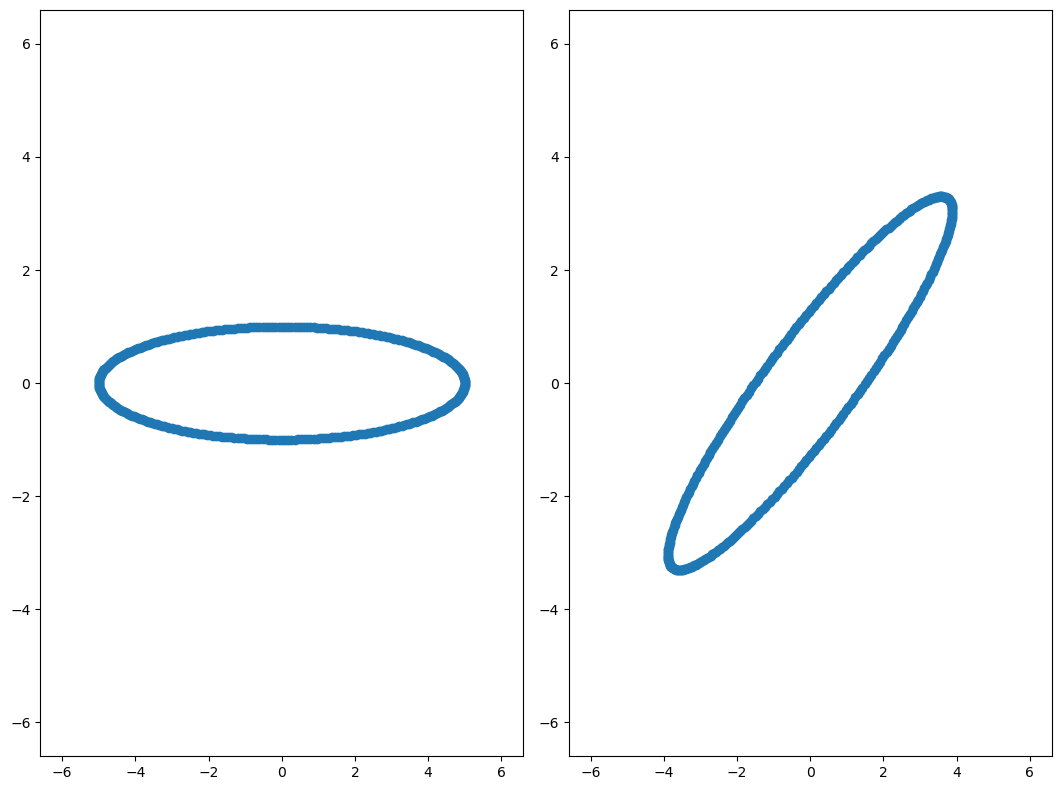

In [6]:
# Ellipse
theta = np.deg2rad(np.arange(0.0, 360.0, 1.0))
a,b=5,1
x = a*np.cos(theta)
y = b*np.sin(theta)
points=np.array([x, y]).T

## Define Transformation
T=Tmatrix(scale=(1,1), rotationAngle=40, shearAngles=(0,0),translation=(0,0),elation=(0,0),reflection=(False,False))

## Apply trasformation
moved = applyTransformation(T, points=points)[0]

fig = plt.figure(figsize=(16, 8))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax1.scatter(points[:,0],points[:,1])
ax2.scatter(moved[:,0],moved[:,1])

minimum = np.min((ax1.get_xlim(),ax1.get_ylim(),ax2.get_xlim(),ax2.get_ylim()))
maximum = np.max((ax1.get_xlim(),ax1.get_ylim(),ax2.get_xlim(),ax2.get_ylim()))

ax1.set_xlim(minimum*1.2,maximum*1.2)
ax1.set_ylim(minimum*1.2,maximum*1.2)
ax2.set_xlim(minimum*1.2,maximum*1.2)
ax2.set_ylim(minimum*1.2,maximum*1.2)

fig.tight_layout()
plt.show()


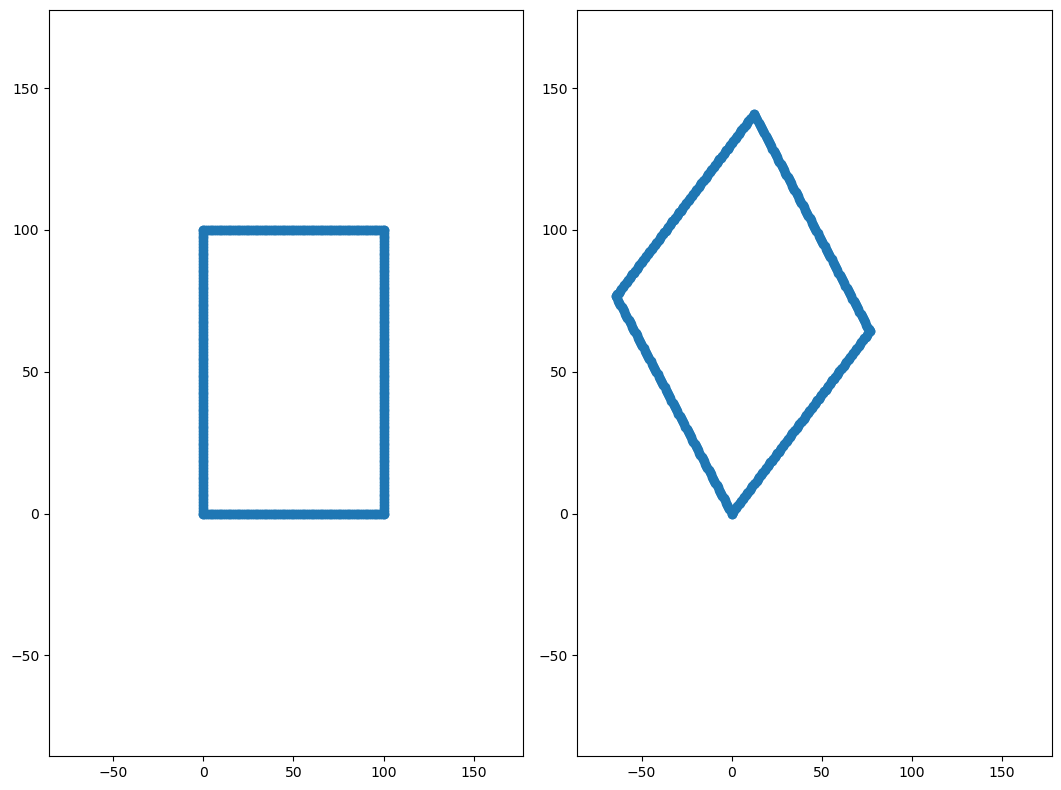

In [7]:
# Square 100x100
x=  np.array((list(range(0,101))+[100 for i in range(101) ]+ list(range(100,-1,-1))+[0 for i in range(101) ] ))
y= np.array(([100 for i in range(101) ]+ list(range(100,-1,-1))+[0 for i in range(101) ] )+list(range(0,101)))
points=np.array([x,y]).T

## Define Transformation
T=Tmatrix(scale=(1,1), rotationAngle=40, shearAngles=(0,0),translation=(0,0),elation=(0,0),reflection=(False,False))

## Apply trasformation
moved = applyTransformation(T, points=points)[0]

fig = plt.figure(figsize=(16, 8))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax1.scatter(points[:,0],points[:,1])
ax2.scatter(moved[:,0],moved[:,1])

minimum = np.min((ax1.get_xlim(),ax1.get_ylim(),ax2.get_xlim(),ax2.get_ylim()))
maximum = np.max((ax1.get_xlim(),ax1.get_ylim(),ax2.get_xlim(),ax2.get_ylim()))

ax1.set_xlim(minimum*1.2,maximum*1.2)
ax1.set_ylim(minimum*1.2,maximum*1.2)
ax2.set_xlim(minimum*1.2,maximum*1.2)
ax2.set_ylim(minimum*1.2,maximum*1.2)

fig.tight_layout()
plt.show()

Now, we can finally move to images. Here, you can load and plot the two images of your (or mine) right hand. Pixel intensities are normalized in order to be float between 0 and 1.

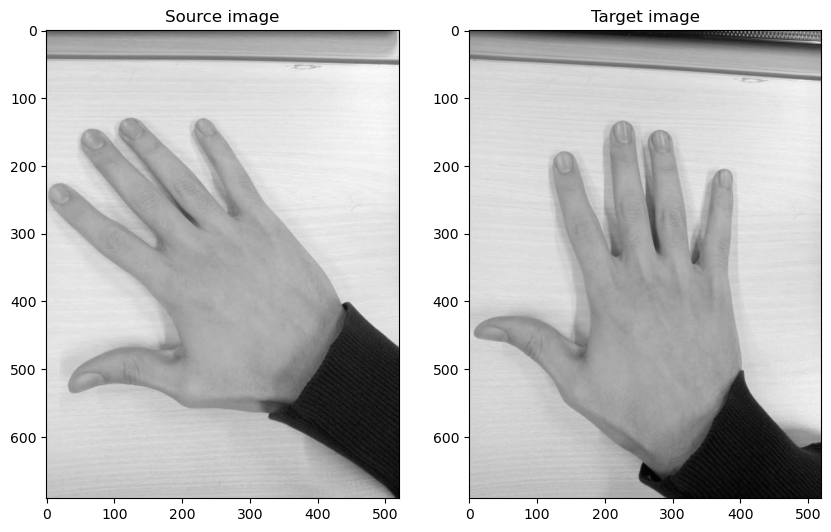

In [8]:
SourceIm = imread(workingDir + 'my_hand1_resized.jpg', as_gray=True)
SourceImNorm=(SourceIm - np.amin(SourceIm)) / (np.amax(SourceIm) - np.amin(SourceIm))
TargetIm = imread(workingDir + 'my_hand2_resized.jpg', as_gray=True)
TargetImNorm=(TargetIm - np.amin(TargetIm)) / (np.amax(TargetIm) - np.amin(TargetIm))

fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
ax1.imshow(SourceImNorm, cmap='gray')
ax1.set_title('Source image')
ax2.imshow(TargetImNorm, cmap='gray')
ax2.set_title('Target image')
plt.show() 


In the following function, you will code the forward warping technique with point splatting. 

Theoretically, an image could be associated with a coordinate chart giving the real-world coordinates of each pixel. However, the problem becomes more difficult and in many applications we do not actually have this coordinate chart. Here, you will simply consider the coordinate of a pixel as its row and column position.

In the forward warping, as seen during the lecture of this morning, the coordinates of a pixel of a source image $I$ might not be warped exactly onto the output grid. When it falls within the grid, but not on the grid, we assign (ie splat) the pixel intensity of $I$ to the four neighbour 'corners' of the output grid. 

These contributions must be weighted and for this reason a typical solution is to create an 'accumulator'. This is an array of the same size of the output grid which quantifies the number of contributions that each corner of the output grid has received. By simply dividing by the number of contributions (output grid ./ accumulator), we obtain at each corner of the output grid an averaged estimate of the intensity of the transformed image.

In [9]:
def ForwardWarping(I,T,coords=None,outputShape=None):
    ''' 
    Apply forward warping to an image I based on a transformation T.
    Transformation is defined by a 3x3 matrix T
        
    Inputs: 
        I: image to transform
        T: 3x3 matrix trasformation
        coords: coordinates of the image. If None, the coordinates of a pixel
                are automatically its row and column position
        outputShape: defines the shape of the transformed image.
                     It can be 'None', same shape as the input image I or 'BB', 
                     bounding box of the transformed image I_T,  or a tuple/numpy
                     array with 4 elements (min x, max x, min y, max y)
                    
    Output:
        J: transformed image
    ''' 

    if coords is None:
      coords = np.mgrid[0:I.shape[0], 0:I.shape[1]] # coordinates of the image I
      cm = applyTransformation(T,coords=coords)[1]

      if outputShape is None:
          outputShape=(0,I.shape[0],0,I.shape[1])
          
      elif outputShape == 'BB':
          #Find extremities bounding box
          bx=int(np.floor(np.min(cm[0,:,:])))
          ux=int(np.ceil(np.max(cm[0,:,:])))
          by=int(np.floor(np.min(cm[1,:,:])))
          uy=int(np.ceil(np.max(cm[1,:,:])))
          outputShape=(bx,ux,by,uy)
          
      elif isinstance(outputShape, tuple):
          if len(outputShape) != 4:
              raise ValueError("Error ! outputShape should be of length 4")           
              
      elif isinstance(outputShape, np.ndarray):
          if len(outputShape) != 4:
              raise ValueError("Error ! outputShape should be of length 4")                                      
      else:
          raise ValueError("Error ! outputShape should be None, 'BB' or a tuple/numpy array with 4 elements")       
      
      bx,ux,by,uy=outputShape                                
      J= np.zeros((ux-bx+1,uy-by+1)) # transformed image
      acc= np.zeros((ux-bx+1,uy-by+1)) # accumulator
      
      #print(bx,ux,by,uy)
      for i in range(I.shape[0]):
          for j in range(I.shape[1]):
              
              # transformed coordinate of a pixel
              p=cm[:,i,j]
              x=p[0]
              y=p[1]
              
              # Check if point is inside outputShape
       #       print(f"i={i},j={j},x={x},y={y}")
              if (x>=bx)and (x<=ux) and (y>=by) and (y<=uy):
                            
                  # translate if necessary, since output image will start from (0,0)                         
                  # it basically shifts transformed points in the positive quadrant
                  if outputShape[0]<0:
                      x=x+abs(outputShape[0])
                      
                  if outputShape[2]<0:
                      y=y+abs(outputShape[2])   
                  
                  # Look for the four corners
                  bl=( int(np.floor(x)), int(np.floor(y)) ) # bottom left
                  br=( int(np.ceil(x)),int( np.floor(y) )) # bottom right
                  ul=( int(np.floor(x)),int( np.ceil(y) )) # up left
                  ur=( int(np.ceil(x)),int(np.ceil(y) ) )# up right
                  
               #   print(f"i={i},j={j},x={x},y={y},bl={bl},br={br},ul={ul},ur={ur}")
                  # Update J and acc
                  J[bl]+=I[i,j]
                  J[br]+=I[i,j]
                  J[ul]+=I[i,j]
                  J[ur]+=I[i,j]
                  
                  acc[bl]+=1
                  acc[br]+=1
                  acc[ul]+=1
                  acc[ur]+=1
      #print((acc==0) .sum())
      acc[acc==0]=1        
      J=np.divide(J,acc)
    
    else:
        raise ValueError("Error ! Still not implemented")
        
    return J

Let's test your implementation of the forward warping with the right hand image. Test with at least 5 different transformation matrices (try different configurations).

In [10]:
# Resize image (to make it faster...)
X= resize(SourceImNorm, (250,250), anti_aliasing=True)
T1=Tmatrix(scale=(5,1), rotationAngle=0, shearAngles=(0,0),translation=(0,0),elation=(0,0),reflection=(False,False))
T2=Tmatrix(scale=(1,1), rotationAngle=90, shearAngles=(0,0),translation=(0,0),elation=(0,0),reflection=(False,False))
T3=Tmatrix(scale=(1,1), rotationAngle=0, shearAngles=(45,37),translation=(0,0),elation=(0,0),reflection=(False,False))
T4=Tmatrix(scale=(1,1), rotationAngle=0, shearAngles=(0,0),translation=(0,0),elation=(0.01,0),reflection=(False,False))
T5=Tmatrix(scale=(1,1), rotationAngle=0, shearAngles=(0,0),translation=(0,0),elation=(0,0),reflection=(False,True))
T6=Tmatrix(scale=(2,3), rotationAngle=45, shearAngles=(0,0),translation=(0,0),elation=(0,0),reflection=(True,False))
T7=Tmatrix(scale=(4,1), rotationAngle=0, shearAngles=(10,5),translation=(0,0),elation=(0,0),reflection=(False,True))
Ts=[T1,T2,T3,T4,T5,T6,T7]

Xmfs =[X]
for T in Ts:    
    Xmf=ForwardWarping(X,T,outputShape="BB")
    Xmfs.append(Xmf)



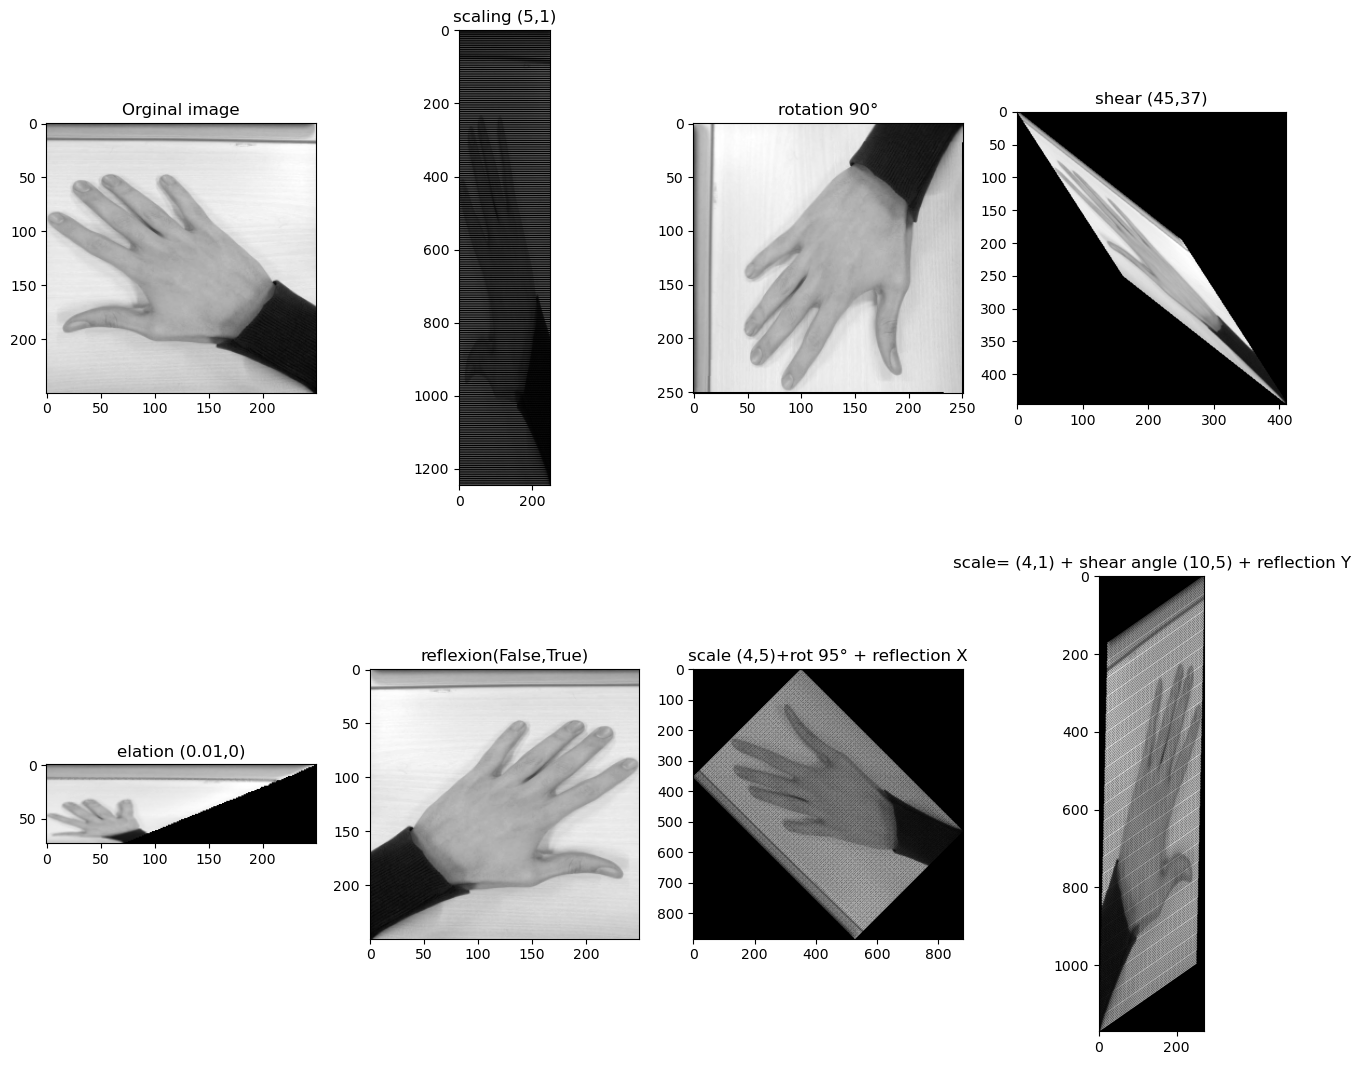

In [11]:
titles=["Orginal image","scaling (5,1)","rotation 90°","shear (45,37)","elation (0.01,0)","reflexion(False,True)","scale (4,5)+rot 95° + reflection X","scale= (4,1) + shear angle (10,5) + reflection Y"]
#print('The transformation matrix T is:\n', T)
fig,axes = plt.subplots(2,4,figsize=(16,13))
for i in range (2):
    for j in range(4) :
        axes[i,j].imshow(Xmfs[4*i+j],cmap='gray')
        axes[i,j].set_title(titles[4*i+j])
plt.show()


Now, we can implement the Inverse Warping (what is usually used as seen this morning).

As before, you will not use external coordinates, the coordinates of a pixel will be its row and column position.

For the interpolation step, you will implement and use the nearest neighbour tehcnique but you can implement and use otherw (e.g. bilinear, cubic, etc.) if you wish.

In [12]:
255.1<255

False

In [116]:
def nearestNeighboutInterp(pM,I,coords=None):
    ''' 
    Nearest Neighbout interpolation
        
    Inputs: 
        pM: 2D point defining the coordinates to interpolate
        I: image used for interpolation
        coords: coordinates of the image. If None, the coordinates of a pixel
                are automatically its row and column position
                    
    Output:
        value: interpolated value at pM
    ''' 
    
    if coords is None:
        # row and column of pM
        r = pM[0]
        c = pM[1]
        
        # check if r and c are within the domain of I (I.shape)
        if (r<I.shape[0]-1 and r>=0 and c<I.shape[1]-1 and c>=0):
                value = I[round(r),round(c)]
        else:
            value=0
        
    else:
        raise ValueError("Error ! Still not implemented")
        value=0
        
    return value

def InverseWarping(I,T,coords=None,outputShape=None):
    ''' 
    Apply inverse warping to an image I based on a transformation T.
    Transformation is defined by a 3x3 matrix
        
    Inputs: 
        I: image to transform
        T: 3x3 matrix trasformation
        coords: coordinates of the image. If None, the coordinates of a pixel
                are automatically its row and column position
        outputShape: defines the shape of the transformed image.
                     It can be 'None', same shape as the input image I or 'BB', 
                     bounding box of the transformed image I_T,  or a tuple/numpy
                     array with 4 elements (min x, max x, min y, max y)
        
            
    Output:
        J: transformed image
    ''' 
    
    if coords is None:
        
        if outputShape is None:
            outputShape=(0,I.shape[0],0,I.shape[1])
            
        elif outputShape == 'BB':
            coords = np.mgrid[0:I.shape[0], 0:I.shape[1]] # coordinates
            cm = applyTransformation(T,coords=coords)[1]
            #Find extremities bounding box
            bx=int(np.floor(np.min(cm[0,:,:])))
            ux=int(np.ceil(np.max(cm[0,:,:])))
            by=int(np.floor(np.min(cm[1,:,:])))
            uy=int(np.ceil(np.max(cm[1,:,:])))
            outputShape=(bx,ux,by,uy)
            
        elif isinstance(outputShape, tuple):
            if len(outputShape) != 4:
                raise ValueError("Error ! outputShape should be of length 4")           
                
        elif isinstance(outputShape, np.ndarray):
            if len(outputShape) != 4:
                raise ValueError("Error ! outputShape should be of length 4")                                      
        else:
            raise ValueError("Error ! outputShape should be None, 'BB' or a tuple/numpy array with 4 elements")       
        bx,ux,by,uy=outputShape                          
        J= np.zeros((ux-bx,uy-by)) # transformed image
        
        invT = np.linalg.inv(T)
        for i in range(J.shape[0]):
            for j in range(J.shape[1]):

                p=np.array([i,j,1]) # coordinate of a pixel to transform
                pM = invT@p # transformed coordinate

                if pM[-1] != 0: 
                  pM = pM/pM[-1] # normalization in case of homography

                  # shifting since the first pixel will be in (0,0) in the output image
                  if outputShape[0]<0:
                      x=i+abs(outputShape[0])
                  else:
                      x=i
                  if outputShape[2]<0:
                      y=j+abs(outputShape[2])
                  else:
                      y=j
                      
                  J[x,y]=nearestNeighboutInterp(pM,I)
    
    else:
        raise ValueError("Error ! Still not implemented")
        
    return J

Let's test the inverse warping and compare it with the implementation of scipy. Test with at least 5 different transformation matrices (try different onfigurations).
Be careful, the implementation of scipy works only with affine transformations.
You can use other implementations from opencv or skimage (even for the projective transformations) if you want. 

The transformation matrix T is:
 [[ 0.70710678  0.06605222 10.        ]
 [ 0.70710678  0.773159   -5.        ]
 [ 0.          0.          1.        ]]


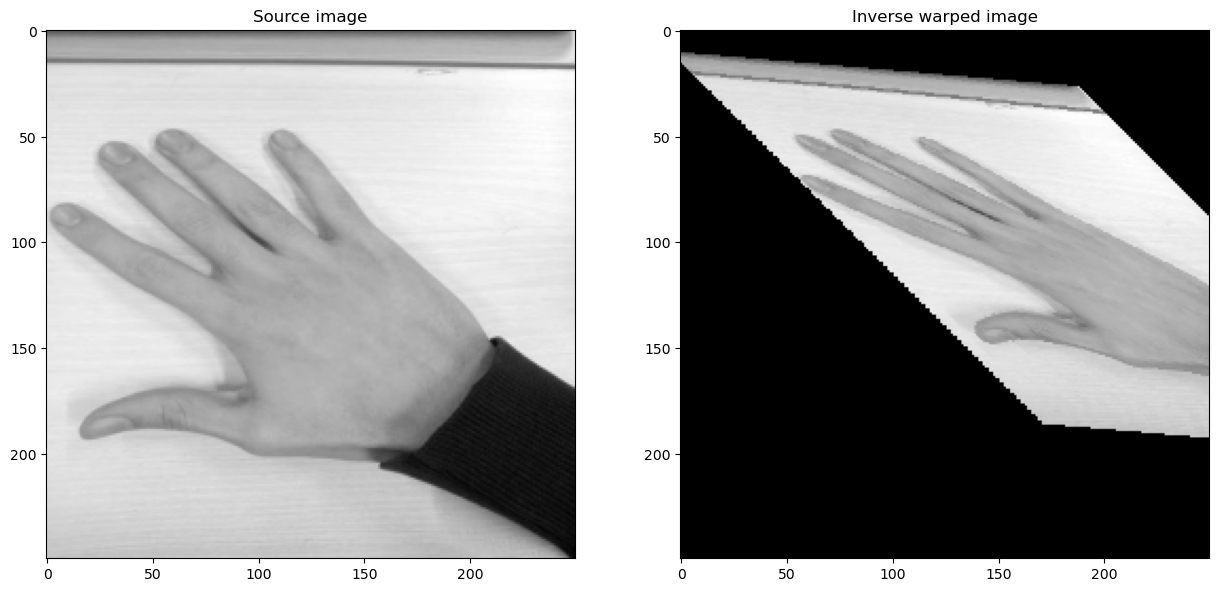

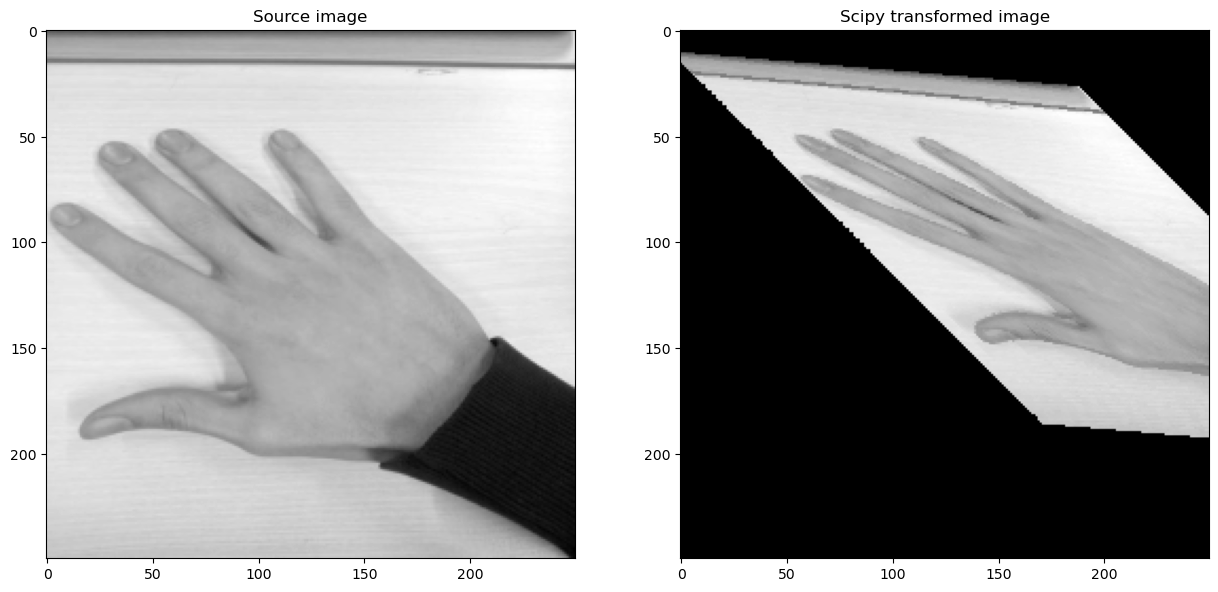

In [117]:
T=Tmatrix(scale=(1,0.5), rotationAngle=45, shearAngles=(34,0),translation=(10,-5),elation=(0,0),reflection=(False,False))
print('The transformation matrix T is:\n', T)

Xmi=InverseWarping(X,T,outputShape=None)
#
fig = plt.figure(figsize=(15, 15))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
ax1.imshow(X, cmap='gray')
ax1.set_title('Source image')
ax2.imshow(Xmi, cmap='gray')
ax2.set_title('Inverse warped image')
plt.show() 



# Only for affine transformations
if T[2,0] ==0 and T[2,1] ==0:
  J=scipy.ndimage.affine_transform(X, LA.inv(T),order=0)
  fig = plt.figure(figsize=(15, 15))
  ax1 = plt.subplot(1, 2, 1)
  ax2 = plt.subplot(1, 2, 2)
  ax1.imshow(X, cmap='gray')
  ax1.set_title('Source image')
  ax2.imshow(J, cmap='gray')
  ax2.set_title('Scipy transformed image')
  plt.show() 


In [118]:
X= resize(SourceImNorm, (250,250), anti_aliasing=True)
T1=Tmatrix(scale=(5,1), rotationAngle=0, shearAngles=(0,0),translation=(0,0),elation=(0,0),reflection=(False,False))
T2=Tmatrix(scale=(1,1), rotationAngle=30, shearAngles=(0,0),translation=(0,0),elation=(0,0),reflection=(False,False))
T3=Tmatrix(scale=(1,1), rotationAngle=0, shearAngles=(45,37),translation=(0,0),elation=(0,0),reflection=(False,False))
T4=Tmatrix(scale=(1,1), rotationAngle=0, shearAngles=(0,0),translation=(20,0),elation=(0,0),reflection=(False,False))
T5=Tmatrix(scale=(2,3), rotationAngle=45, shearAngles=(0,0),translation=(0,0),elation=(0,0),reflection=(True,False))
T6=Tmatrix(scale=(4,1), rotationAngle=0, shearAngles=(10,5),translation=(0,0),elation=(0,0),reflection=(False,False))
Ts=[T1,T2,T3,T4,T5,T6]

# my implementation 
Xmis =[]
for T in Ts:    
    Xmi=InverseWarping(X,T,outputShape=None)
    Xmis.append(Xmi)

# scipy implementation
Js = []
for T in Ts:    
    J=scipy.ndimage.affine_transform(X, LA.inv(T),order=0)
    Js.append(J)


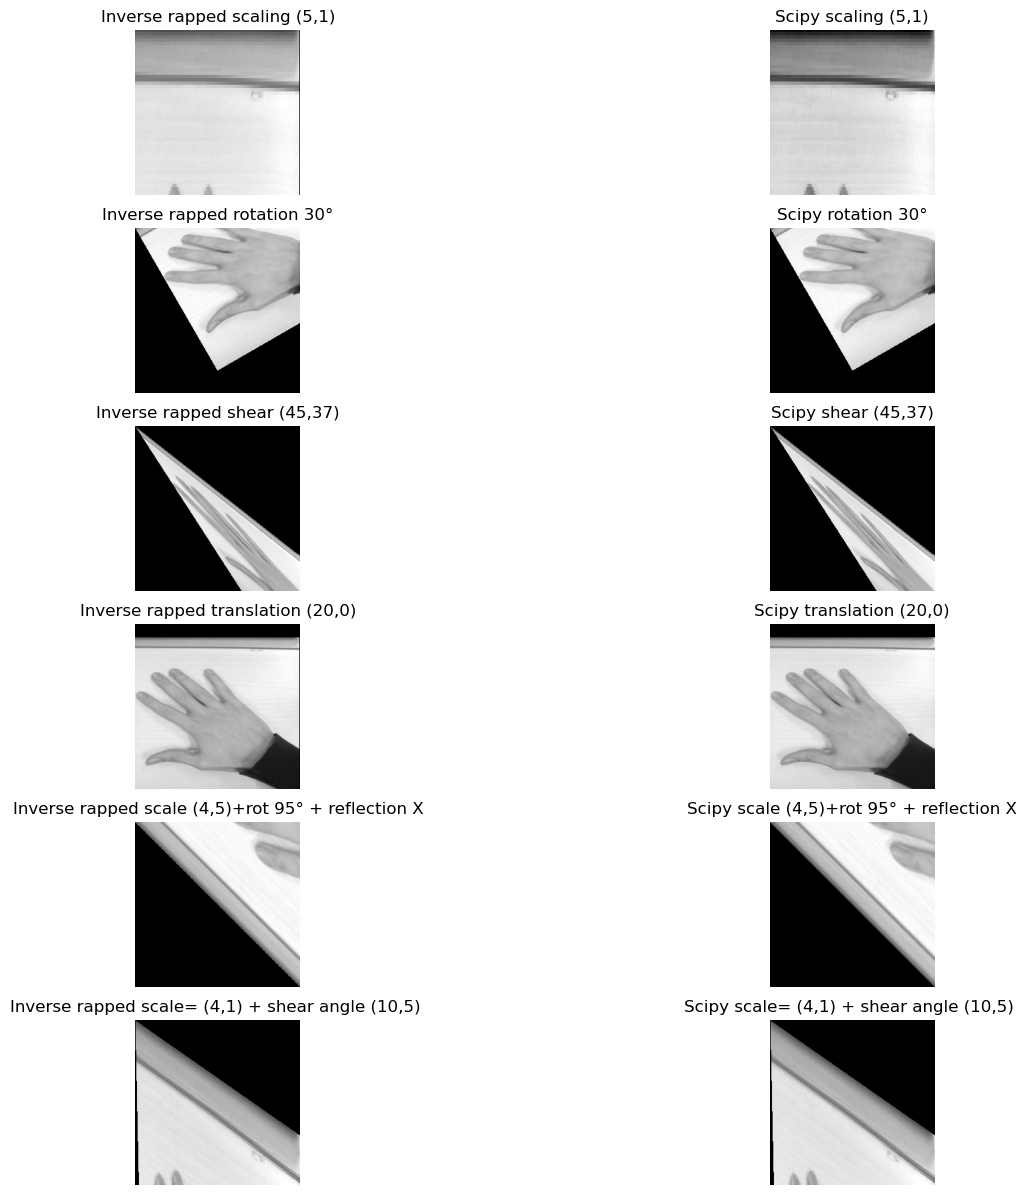

In [119]:
titles=["scaling (5,1)","rotation 30°","shear (45,37)","translation (20,0)","scale (4,5)+rot 95° + reflection X","scale= (4,1) + shear angle (10,5) "]
#print('The transformation matrix T is:\n', T)
fig,axes = plt.subplots(6,2,figsize=(15,15))
for i in range (6):
        axes[i,0].imshow(Xmis[i],cmap='gray')
        axes[i,0].set_title("Inverse rapped "+titles[i])
        axes[i,1].imshow(Js[i],cmap='gray')
        axes[i,1].set_title("Scipy " + titles[i])
        axes[i,0].axis("off")
        axes[i,1].axis("off")
plt.show()

**(OPTIONAL)** Implement the Lucas-Kanade Algorithm to register the source image to the target image.²

In [120]:
import math
def dericheGradX(ima,alpha=0.6):
    nl,nc=ima.shape
    ae=math.exp(-alpha)
    c=-(1-ae)*(1-ae)/ae

    b1=np.zeros(nc)
    b2=np.zeros(nc)

    gradx=np.zeros((nl,nc))

    for i in range(nl):
        
        l=ima[i,:].copy()
        
        for j in range(2,nc):
            b1[j] = l[j-1]+2*ae*b1[j-1]-ae*ae*b1[j-2]     # LIGNE A MODIFIER
        b1[0]=b1[2]
        b1[1]=b1[2]
        
        for j in range(nc-3,-1,-1):
            b2[j] = l[j+1] + 2*ae*b2[j+1]-ae*ae*b2[j+2]    # LIGNE A MODIFIER
        b2[nc-2]=b2[nc-3]
        b2[nc-1]=b2[nc-3]

        gradx[i,:]=c*ae*(b1-b2);
  
    return gradx
        
def dericheGradY(ima,alpha=0.6):

    
    nl,nc=ima.shape
    ae=math.exp(-alpha)
    c=-(1-ae)*(1-ae)/ae

    b1=np.zeros(nl)
    b2=np.zeros(nl)

    grady=np.zeros((nl,nc))

    for i in range(nc):
        
        l=ima[:,i].copy()
        
        for j in range(2,nl):
            b1[j] = l[j-1]+2*ae*b1[j-1]-ae*ae*b1[j-2]    # LIGNE A MODIFIER
        b1[0]=b1[2]
        b1[1]=b1[2]      
        
        for j in range(nl-3,-1,-1):
             b2[j] = l[j+1] + 2*ae*b2[j+1]-ae*ae*b2[j+2]  # LIGNE A MODIFIER
        b2[nl-1]=b2[nl-3]
        b2[nl-2]=b2[nl-3]
        
        grady[:,i]=c*ae*(b1-b2);
           
    return grady

iteration 0
 
current theta = [[-30.00457311]
 [  0.99628876]
 [  0.99734666]
 [ -0.74656032]
 [199.92340551]]


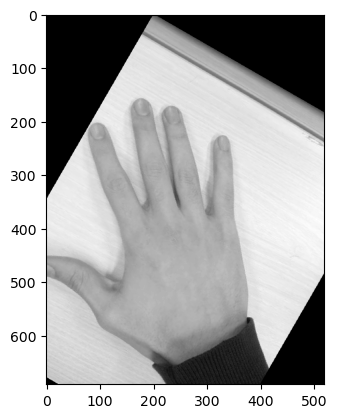

iteration 1
 
current theta = [[-30.00076682]
 [  0.99678468]
 [  1.00138399]
 [ -0.58968571]
 [200.82123596]]


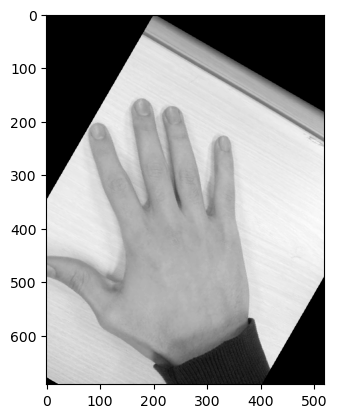

iteration 2
 
current theta = [[-29.99703566]
 [  0.99730785]
 [  1.00535117]
 [ -0.44447042]
 [201.7182939 ]]


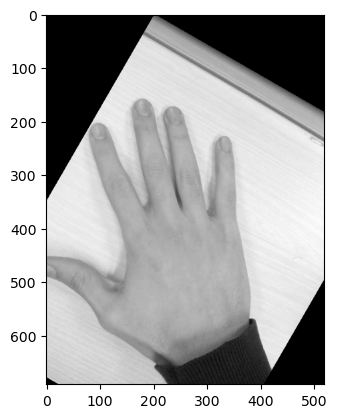

iteration 3
 
current theta = [[-29.99338024]
 [  0.99785543]
 [  1.00925002]
 [ -0.31166796]
 [202.61451515]]


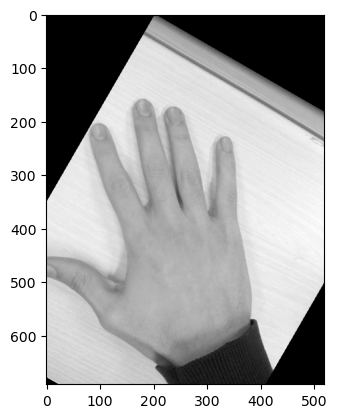

iteration 4
 
current theta = [[-2.99897983e+01]
 [ 9.98426195e-01]
 [ 1.01308446e+00]
 [-1.90004074e-01]
 [ 2.03507742e+02]]


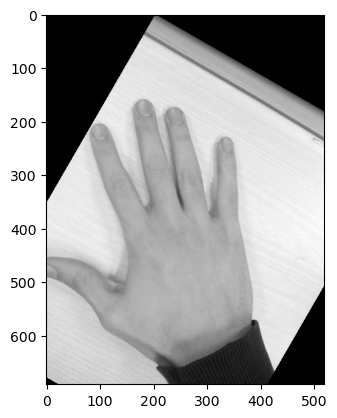

iteration 5
 
current theta = [[-2.99862945e+01]
 [ 9.99015585e-01]
 [ 1.01685289e+00]
 [-8.03393769e-02]
 [ 2.04399249e+02]]


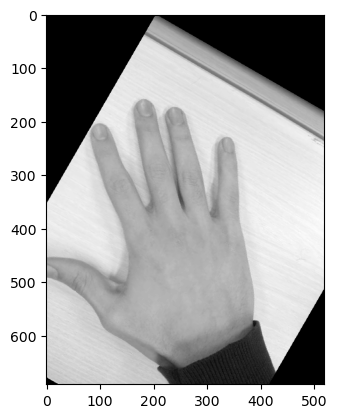

In [137]:
I=SourceImNorm
J=TargetImNorm
r,c = J.shape
theta_0 = np.array([[-30,1.,1.,0.,200]]).T # these parameters are rotation angle, scalex, scaley, translation x,y
max_K= 5
k = 0
eps=0.005
tau = 5
d_theta=np.ones((5,1))
theta=theta_0
I_T = I # here we set the intial value of the transformed I to itself since the intial parameters gives us the idenitity T

while(np.linalg.norm(theta)>=eps and np.linalg.norm(J-I_T) >= tau and k <=max_K):
    d_theta =np.zeros((5,1))
    H= np.zeros((5,5))
    print(f"iteration {k}\n ")

    gradx=dericheGradX(I_T)
    grady=dericheGradY(I_T)
    grad_I_T=np.dstack((gradx,grady)).reshape(([I_T.shape[0],I_T.shape[1],2,1]))
    for u in range(r):
        for v in range(c):
            jacob = np.array([[ (-np.sin(theta[0,0])*theta[1,0] -np.cos(theta[0,0])*theta[2,0])*u + (np.sin(theta[0,0])*theta[1,0]-np.cos(theta[0,0])*theta[2,0])*v,np.cos(theta[0,0])*u+np.cos(theta[0,0])*v, np.sin(theta[0,0])*u-np.sin(theta[0,0])*v ,1,0],[(np.cos(theta[0,0])*theta[1,0]-np.sin(theta[0,0])*theta[1,0] )*u +(theta[1,0]*np.cos(theta[0,0])-np.sin(theta[0,0])*theta[2,0])*v  , np.sin(theta[0,0])*u+np.sin(theta[0,0])*v , np.cos(theta[0,0])*u+ np.sin(theta[0,0])*v ,0,1      ]       ]) 
            #print(f" np.transpose(grad_I_T[u,v]){ np.transpose(grad_I_T[u,v])} \n jacob {jacob} I_T[u,v] {I_T[u,v]}")
            d_theta += np.transpose(np.transpose(grad_I_T[u,v])@jacob     )*(J[u,v]-I_T[u,v])
            
            H+= np.transpose(np.transpose(grad_I_T[u,v])@jacob     )@(np.transpose(grad_I_T[u,v])@jacob     )
    
    d_theta = np.linalg.inv(H)@d_theta
    k=k+1
    
    theta+= d_theta 
    T= Tmatrix(scale=(theta[1,0],theta[2,0]), rotationAngle=theta[0,0], shearAngles=(0,0),translation=(theta[3,0],theta[4,0]),elation=(0,0),reflection=(False,False))
    I_T = InverseWarping(I,T,outputShape=(0,J.shape[0],0,J.shape[1]))
    print(f"current theta = {theta}")
    plt.imshow(I_T,cmap='gray')
    plt.show()
    

iteration 0
 
current theta = [[-2.99993000e+01]
 [-7.59540780e-02]
 [ 1.99342416e+02]]


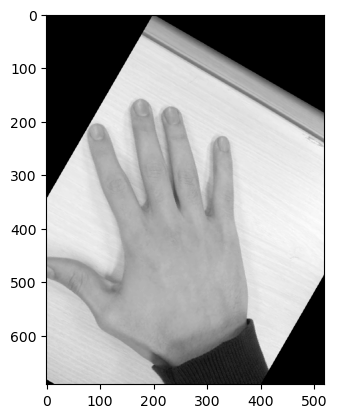

iteration 1
 
current theta = [[-2.99986630e+01]
 [-7.75915676e-02]
 [ 2.00192738e+02]]


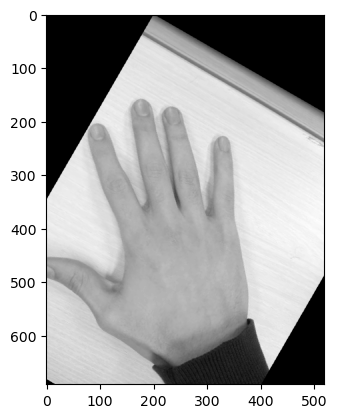

iteration 2
 
current theta = [[-2.99980425e+01]
 [-8.11398518e-02]
 [ 2.01037568e+02]]


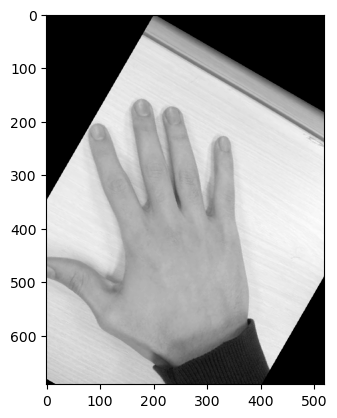

iteration 3
 
current theta = [[-2.99974329e+01]
 [-8.65727331e-02]
 [ 2.01879113e+02]]


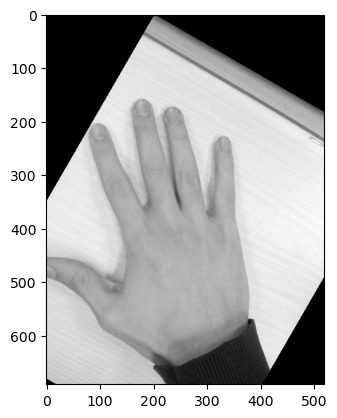

iteration 4
 
current theta = [[-2.99968403e+01]
 [-9.44767464e-02]
 [ 2.02715592e+02]]


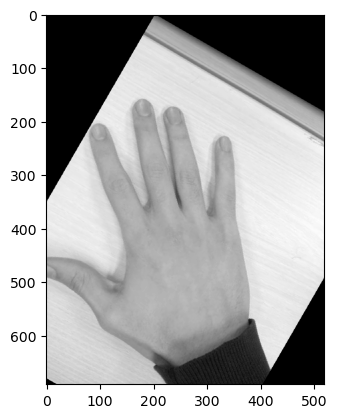

iteration 5
 
current theta = [[-2.99962574e+01]
 [-1.04502996e-01]
 [ 2.03550114e+02]]


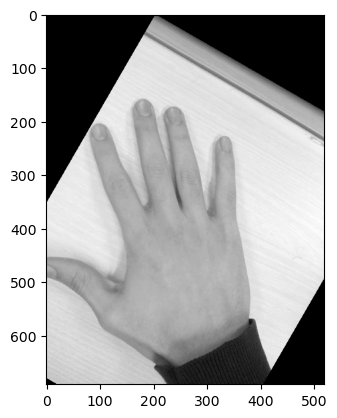

In [138]:
I=SourceImNorm
J=TargetImNorm
r,c = J.shape
theta_0 = np.array([[-30,0.,200]]).T # these parameters are rotation angle, scalex, scaley, translation x,y
max_K= 5
k = 0
eps=0.005
tau = 5
d_theta=np.ones((3,1))
theta=theta_0
I_T = I # here we set the intial value of the transformed I to itself since the intial parameters gives us the idenitity T

while(np.linalg.norm(theta)>=eps and np.linalg.norm(J-I_T) >= tau and k <=max_K):
    d_theta =np.zeros((3,1))
    H= np.zeros((3,3))
    print(f"iteration {k}\n ")

    gradx=dericheGradX(I_T)
    grady=dericheGradY(I_T)
    grad_I_T=np.dstack((gradx,grady)).reshape(([I_T.shape[0],I_T.shape[1],2,1]))
    for u in range(r):
        for v in range(c):
            jacob = np.array( [[ -np.sin(theta[0,0])*u - np.cos(theta[0,0])*v, 1,0],[np.cos(theta[0,0])*u -np.sin(theta[0,0])*v  ,0,1      ]       ]) 
            #print(f" np.transpose(grad_I_T[u,v]){ np.transpose(grad_I_T[u,v])} \n jacob {jacob} I_T[u,v] {I_T[u,v]}")
            d_theta += np.transpose(np.transpose(grad_I_T[u,v])@jacob     )*(J[u,v]-I_T[u,v])
            
            H+= np.transpose(np.transpose(grad_I_T[u,v])@jacob     )@(np.transpose(grad_I_T[u,v])@jacob     )
    
    d_theta = np.linalg.inv(H)@d_theta
    k=k+1
    
    theta+= d_theta 
    T= Tmatrix(scale=(1,1), rotationAngle=theta[0,0], shearAngles=(0,0),translation=(theta[1,0],theta[2,0]),elation=(0,0),reflection=(False,False))
    I_T = InverseWarping(I,T,outputShape=(0,J.shape[0],0,J.shape[1]))
    print(f"current theta = {theta}")
    plt.imshow(I_T,cmap='gray')
    plt.show()
    

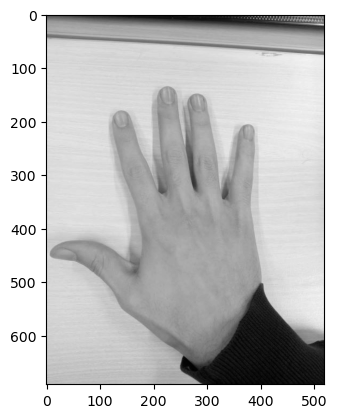

In [140]:
plt.imshow(J,cmap="gray")